In [19]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

Я честно пыталась научить нейросеть без сжатия изображений, и у меня даже получилось, но вот чтобы получить предсказания 12.5к файлов мне предлагало ждать 500 часов. Поэтому, так как в формулировке дз нет требуемой метрики, я схитрю и сделаю совершенно бессмысленную нейросеть, которая будет непонятно как предсказывать на сжатых изображениях. Зато я смогу загрузить файл в нужном формате на kaggle и получу какую-то (очень плохую) метрику.

In [221]:
files = os.listdir('C:/Users/ksurashanti/anaconda ml/5.3/input/the-nature-conservancy-fisheries-monitoring/train/')

In [ ]:
#переименовываем изображения, цепляем метку к названию изображения
import os
ext = 'ALB'
path = 'C:/Users/ksurashanti/anaconda ml/5.3/input/the-nature-conservancy-fisheries-monitoring/train/ALB'
for file in os.listdir(path):
#    print(file)
#    print(os.listdir(path))
    os.rename(f'C:/Users/ksurashanti/anaconda ml/5.3/input/the-nature-conservancy-fisheries-monitoring/train/ALB/{file}', 
              f'C:/Users/ksurashanti/anaconda ml/5.3/input/the-nature-conservancy-fisheries-monitoring/train/ALB/{ext}_{file}')

In [ ]:
from PIL import Image #итерируется по всем фотографиям в директории и сжимаем для ускорения процесса

for f in files:
    image_path = f'C:/Users/ksurashanti/anaconda ml/5.3/input/the-nature-conservancy-fisheries-monitoring/train/{f}'
    img = Image.open(image_path)
    img.thumbnail(size=(224,224)) #сожму как были сжаты коты в предыдущем дз, они с неплохо скоростью смогли обучиться
    img.save(f'C:/Users/ksurashanti/anaconda ml/5.3/input/the-nature-conservancy-fisheries-monitoring/train/{f}')

In [229]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('C:/Users/ksurashanti/anaconda ml/5.3/input/the-nature-conservancy-fisheries-monitoring/train/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([0. if os.path.basename(path).startswith('ALB') 
                          else 1. if os.path.basename(path).startswith('BET')
                          else 2. if os.path.basename(path).startswith('DOL')
                          else 3. if os.path.basename(path).startswith('LAG')
                          else 4. if os.path.basename(path).startswith('NoF')
                          else 5. if os.path.basename(path).startswith('OTHER')
                          else 6. if os.path.basename(path).startswith('SHARK')
                          else 7.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([0. if os.path.basename(path).startswith('ALB') 
                          else 1. if os.path.basename(path).startswith('BET')
                          else 2. if os.path.basename(path).startswith('DOL')
                          else 3. if os.path.basename(path).startswith('LAG')
                          else 4. if os.path.basename(path).startswith('NoF')
                          else 5. if os.path.basename(path).startswith('OTHER')
                          else 6. if os.path.basename(path).startswith('SHARK')
                          else 7.
                          for path in files[i:j]])
            yield (x, y)


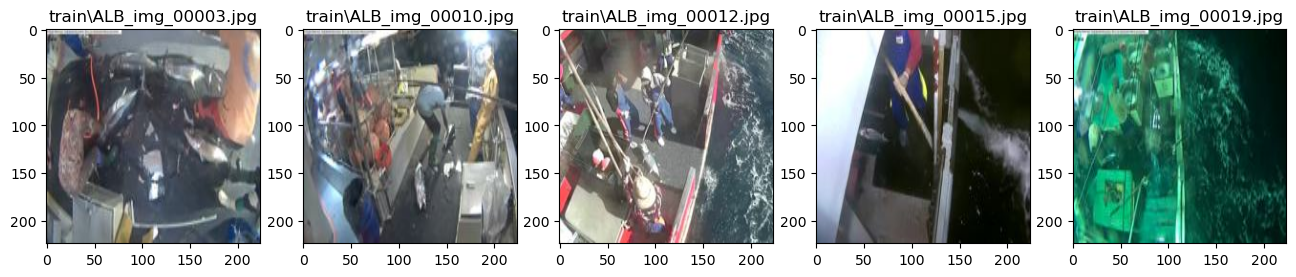

In [231]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:5], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)
plt.show()

In [233]:
# base_model - объект класса keras.models.Model (Functional Model)
#будем использовать предобученную модель, так как это здорово экономит вычислительные ресурсы
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [235]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [237]:
# фиксируем все веса предобученной сети
for layer in base_model.layers: #итерируемся по слоям НС и параметром trainable = false, т.е эти слои выключим из обучения
    layer.trainable = False

x = base_model.layers[-2].output #получаем пятый с конца слой и модифицируем НС
x = tf.keras.layers.Flatten()(x) #воспользуемся выходом и добавим полносвязный слой, который и будем дальше учить
#то есть мы учим все слови до пятого с конца, а начиная с этого места добавляем полносвязный слой
x = tf.keras.layers.Dense(8,  # 
                          activation='softmax',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)


model = tf.keras.Model(inputs=base_model.input, outputs=x, name='fishes_mmm')

In [239]:
model.summary()

Model: "fishes_mmm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │       802,824 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,517,512 (59.19 MB)

 Trainable params: 802,824 (3.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [241]:
model.compile(optimizer='adam', #компилируем модель
              loss='SparseCategoricalCrossentropy',  #используется для многоклассовой классификации
              metrics=['accuracy'])

In [245]:
#запускаем обучение на 10 эпох
val_samples = 8  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=8,  # число вызовов генератора за эпоху
          epochs=10,  # число эпох обучения
          validation_data=validation_data)
#есть метрики по трэйн(в начале) и тест данным(в конце)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9078 - loss: 5.4884 - val_accuracy: 0.8750 - val_loss: 1.2855
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9290 - loss: 3.7122 - val_accuracy: 0.8750 - val_loss: 4.6508
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9246 - loss: 2.6326 - val_accuracy: 0.8750 - val_loss: 0.9814
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8755 - loss: 6.9960 - val_accuracy: 0.7500 - val_loss: 14.4307
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8521 - loss: 7.2788 - val_accuracy: 0.8750 - val_loss: 6.5787
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9419 - loss: 2.9166 - val_accuracy: 0.7500 - val_loss: 5.1480
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9675 - loss: 1.9881 - val_accuracy: 0.7500 - val_loss: 10.6865
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9415 - loss: 3.9245 - val_accuracy: 0.8750 - val_loss: 9.7575
Epoch 

Так как у меня нет 700 часов ждать обучения, сожму и изображения:

In [255]:
files = os.listdir('D:/netology/007/test')

In [257]:
from PIL import Image #итерируется по всем фотографиям в директории и сжимаем

for f in files:
    image_path = f'D:/netology/007/test/{f}'
    img = Image.open(image_path)
    img.thumbnail(size=(224,224))
    img.save(f'D:/netology/007/test/{f}')

А теперь можно и предсказать!

In [438]:
test_files = glob('C:/Users/ksurashanti/anaconda ml/5.3/input/test_stg2/test_stg2/*.jpg')

In [440]:
len(test_files)

12153

In [265]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12153/12153 ━━━━━━━━━━━━━━━━━━━━ 29853s 2s/step


In [277]:
test_pred

array([[1.01593414e-22, 2.39058018e-23, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 2.42510927e-36, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.82525846e-02, 6.24919588e-38, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.61747408e-01],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.29504488e-25],
       [1.52914552e-08, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.17325605e-27, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.23217671e-15]], dtype=float32)

In [271]:
test_pred.shape

(388896, 8)

In [424]:
files = os.listdir('D:/netology/007/test_stg1')

In [426]:
from PIL import Image #итерируется по всем фотографиям в директории и сжимаем

for f in files:
    image_path = f'D:/netology/007/test_stg1/{f}'
    img = Image.open(image_path)
    img.thumbnail(size=(224,224))
    img.save(f'D:/netology/007/test/{f}')

In [446]:
test_files = glob('D:/netology/007/test_stg1/*.jpg')

In [448]:
len(test_files)

1000

In [432]:
test_pred2 = model.predict(
    predict_generator(test_files), steps=len(test_files))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2445s 2s/step


In [462]:
test_pred.shape

(388896, 8)

In [466]:
type(test_pred2)

numpy.ndarray

In [468]:
test_pred_all = np.vstack([test_pred, test_pred2])
test_pred_all.shape

(420896, 8)

In [470]:
test_files = os.listdir('C:/Users/ksurashanti/anaconda ml/5.3/input/TEST')

In [474]:
import re

with open('submit_all.csv', 'w') as dst:
    dst.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT')
    for path, score in zip(test_files, test_pred_all):
        lst = [score[0], score[1], score[2], score[3], score[4], score[5], score[6], score[7]]
  #      print(lst)
        pred = ','.join(str(el) for el in lst)
 #       print((re.search('image_\d+.jpg', path)).group(0)+','+pred)
        dst.write('\n'+(re.search('(image_|img_)\d+.jpg', path)).group(0)+','+pred)

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ksurashanti\AppData\Local\Temp\ipykernel_1924\3331215187.py:10: SyntaxWarning: invalid escape sequence '\d'
  dst.write('\n'+(re.search('(image_|img_)\d+.jpg', path)).group(0)+','+pred)


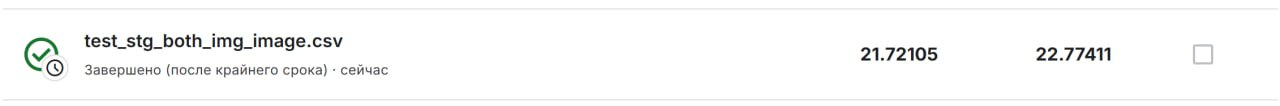

In [476]:
from IPython.display import Image
Image('kaggle.jpg') 